In this notebook we explore more about eye tracking data analysis

In [1]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

In [2]:
subject_idx = 1
T_idx = 1

if T_idx == 1:
    mode = 'T1'
else:
    mode = 'T2'
    
BIDS_PATH = Path("/Users/cag/Documents/Dataset/MREyeTrack/EDF")

if subject_idx == 1:    
    FILE_NAME = f"000001_fixed_dot-16_grid_T1w_2024-10-14_17h24"    
elif subject_idx == 2:
    FILE_NAME = f"000002_fixed_dot-16_grid_T1w_2024-10-14_16h54" 
elif subject_idx == 3: 
    FILE_NAME = f"000003_fixed_dot-16_grid_T1w_2024-10-14_16h35"
    # "OT4.EDF"
else:
    FILE_NAME = f""
    
# D:\Eye_Dataset\Sub001\230928_anatomical_MREYE_study\ET_EDF
session = "001" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"
gif_name = f'{FILE_NAME}.gif'


In [3]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
recording.head()
print(f'recording len: {len(recording)}')
metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
# print(f'meta_data: {metadata}')

print('The duration of mri acquisition sub001 sub002 and sub003: 655240 ms')


recording_file: /Users/cag/Documents/Dataset/MREyeTrack/EDF/000001_fixed_dot-16_grid_T1w_2024-10-14_17h24.tsv.gz
recording len: 657900
The duration of mri acquisition sub001 sub002 and sub003: 655240 ms


# Metadata and calibration

We always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [4]:

target_message = "ET: Start routine 'centered_dot'"
target_timestamp = 0
for index, element in enumerate(metadata['LoggedMessages']):
    if element[1] == target_message:
        print(f"First occurrence is at index {index}: {element}")
        target_timestamp = element[0]
        print(f"at timestamp {target_timestamp}")
        break
gap_start_dot = target_timestamp - metadata['StartTime']
# gap_start_dot = 0
print(f"Timestamp to start recording: {metadata['StartTime']}")
print(f'From the start of recording to the first dot: {gap_start_dot}')

First occurrence is at index 27: [15155843, "ET: Start routine 'centered_dot'"]
at timestamp 15155843
Timestamp to start recording: 15155345
From the start of recording to the first dot: 498


In [5]:
if subject_idx == 1:
    print(recording[655335:655338])
    # 655336 timestamp 15810681
    # From there it became NaN

        Unnamed: 0  eye1_x_coordinate  eye1_y_coordinate  eye1_pupil_size  \
655335      655335         443.899994         471.299988           1594.0   
655336      655336         443.899994         471.299988           1594.0   
655337      655337                NaN                NaN              NaN   

        eye1_pupil_x_coordinate  eye1_pupil_y_coordinate  \
655335                  -5161.0                  -2741.0   
655336                  -5161.0                  -2741.0   
655337                 -32768.0                 -32768.0   

        eye1_href_x_coordinate  eye1_href_y_coordinate  fast_href_x_velocity  \
655335                   434.0                  1691.0         -1.946136e+14   
655336                   434.0                  1691.0         -1.946136e+14   
655337                 -7936.0                 -7936.0         -1.946136e+14   

        fast_raw_x_velocity  screen_ppdeg_x_coordinate  \
655335         2.161728e+20                  26.700001   
655336       

In [6]:
t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]*1000
print(f"The end of the timestamp: {t_axis[-1]}")

The end of the timestamp: 657899.0


In [7]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
print(metadata["Columns"])

['eye1_x_coordinate', 'eye1_y_coordinate', 'eye1_pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_href_x_velocity', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'eye1_saccade', 'eye1_blink']
['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_href_x_velocity', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade', 'blink']


In [8]:
recording.columns

Index(['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size',
       'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate',
       'eye1_href_x_coordinate', 'eye1_href_y_coordinate',
       'fast_href_x_velocity', 'fast_raw_x_velocity',
       'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp',
       'fixation', 'saccade', 'blink'],
      dtype='object')

In [9]:
# See cleaned cell 4

In [10]:
plot_pupil_saccade = False

if plot_pupil_saccade:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((200, 220))
    plt.title('Pupil area and saccading')
    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

In [11]:
plot_x_saccade = False
if plot_x_saccade:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 1000,
    )
    plt.xlim((200, 220))

Check fixation

In [12]:
plot_fixation = False
if plot_fixation:
    # Fixation
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('X coordinate of gazing with fixation')

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["y_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('Y coordinate of gazing with fixation')

The analysis did not reveal a strong correlation between pupil size and saccade or fixation events.

The coordinate sequence is stable during fixation, we should extract the data in the event.

# Data Cleaning

- Seperate the two phases of sequences
- Extract the X Y coordinates
- Eliminate the blinking and non-fixation area of LIBRE data, and keep the raw data of STANDARD.Because there is no mechanism for the second STANDARD one to correct the eye fixation.
- Design some criteria for cleaning the noise data
    - Visual angle
    - Heat maps
    - Fixation algorithm (literature review)

### Seperate the two phases of sequences

In [13]:
# -----------------------------
reset_index_bool = False
eliminate_all_nan = False
eliminate_first_nan = False
# -----------------------------

size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)

coor_data = recording[["x_coordinate", "y_coordinate"]]
print(f"Extract X Y coordinates from recording: {len(coor_data)}")

if eliminate_all_nan:
    coor_data = coor_data[coor_data.x_coordinate.notna() & coor_data.y_coordinate.notna()]
    coor_recording = recording[recording.x_coordinate.notna() & recording.y_coordinate.notna()]
elif eliminate_first_nan:
    # Find the first non-NaN row
    first_valid_index = coor_data[['x_coordinate', 'y_coordinate']].dropna(how='all').index[0]

    # Slice the DataFrame from the first non-NaN row onward
    coor_data = coor_data.iloc[first_valid_index:]
    
    coor_recording = recording.iloc[first_valid_index:]
    
else:
    coor_recording = recording

if reset_index_bool:
    coor_data.reset_index(drop=True, inplace=True)
    coor_recording.reset_index(drop=True, inplace=True)
    
print(coor_data)
print(f"Eliminating nan values? {eliminate_first_nan}: {len(coor_data)}")
print(f'len of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')

Extract X Y coordinates from recording: 657900
        x_coordinate  y_coordinate
0         466.899994    279.200012
1         466.899994    279.899994
2         466.899994    279.799988
3         465.500000    280.399994
4         464.100006    281.000000
...              ...           ...
657895           NaN           NaN
657896           NaN           NaN
657897           NaN           NaN
657898           NaN           NaN
657899           NaN           NaN

[657900 rows x 2 columns]
Eliminating nan values? False: 657900
len of coor_data 657900 should be equal to len of coor_recording 657900


In [14]:
# Duration setting according to the protocol (in sec) not any more
# Duration setting according to the raw data info


T1_LIBRE = (len(coor_data) - gap_start_dot)/metadata['SamplingFrequency']
    
T1_GAP = 0
T1_VIBE = 0


print(f"The length of T1_LIBRE Subject{subject_idx} should be: {T1_LIBRE} sec (len(coor_data)-gap_start_dot)")


The length of T1_LIBRE Subject1 should be: 657.402 sec (len(coor_data)-gap_start_dot)


mode: T1
set start margin as 498
657402


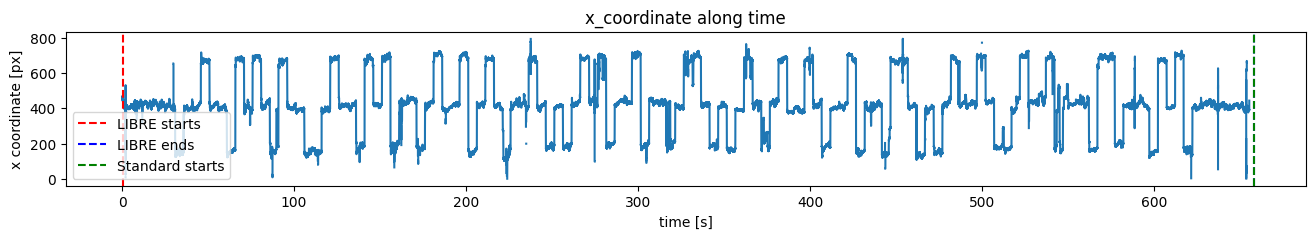

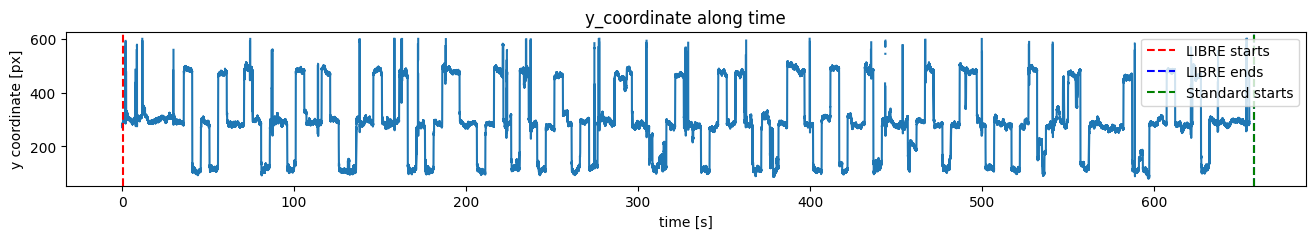

In [15]:
start_margin = int(gap_start_dot)
if mode == 'T1':
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T1_LIBRE_sample = T1_LIBRE*metadata['SamplingFrequency']
    T1_GAP_sample = T1_GAP*metadata['SamplingFrequency']
    T1_VIBE = len(coor_data) - T1_LIBRE_sample - T1_GAP_sample
else:
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T2_LIBRE_sample = T2_LIBRE*metadata['SamplingFrequency']
    T2_GAP_sample = T2_GAP*metadata['SamplingFrequency']
    T2_TSE = len(coor_data) - T2_LIBRE_sample - T2_GAP_sample
    


t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values,
)

if mode == 'T1':
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")
plt.legend()

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values,
)

plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
plt.axvline(x=(T1_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
            linestyle='--', label='Standard starts')

    
plt.title("y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")
plt.legend()


coor_data_LIBRE = coor_data[start_margin:int(T1_LIBRE_sample)+start_margin] 
coor_recording_LIBRE = coor_recording[start_margin:int(T1_LIBRE_sample)+start_margin] 
coor_data_LIBRE_raw = copy.deepcopy(coor_data_LIBRE)
print(len(coor_data_LIBRE))


In [16]:
# import scipy.io
# coor_array = coor_data_LIBRE[['x_coordinate', 'y_coordinate']].to_numpy()
# scipy.io.savemat(f'coor_data_raw_t1w_libre_sub00{subject_idx}.mat', {'coordinates': coor_array})

### Eliminating blinking

In [17]:
use_eliminate_blink = True

def eliminate_blink(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.blink < 1]
#     coor_recording = coor_recording[coor_recording.blink < 1]
# Note: instead of filtering them out, I assign nan to the invalid elements
    print(f'The data will be eliminated: {len(coor_data[coor_recording.blink > 0])}')
    coor_data.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    print(f'After eliminating blinking: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_eliminate_blink:
    coor_data_LIBRE,  coor_recording_LIBRE = eliminate_blink(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
# coor_data_STANDARD,  coor_recording_STANDARD = eliminate_blink(coor_data_STANDARD, 
#                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 11775
After eliminating blinking: 
len of coor_data_LIBRE 657402       should be equal to len of coor_recording 657402


/var/folders/x4/yl1kbpks5sxc3345y3ttk6gm0000gn/T/ipykernel_3012/395681592.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coor_data.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan


In [18]:
# coor_data_LIBRE[coor_recording_LIBRE.blink > 0]

### Preserving fixation

In [19]:
use_preserve_fixation = True

def preserve_fixation(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.fixation > 0]
#     coor_recording = coor_recording[coor_recording.fixation > 0]
    print(f'The data will be eliminated: {len(coor_data[coor_recording.fixation < 1])}')
    coor_data.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan

    print(f'After preserving fixation: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_preserve_fixation:
    coor_data_LIBRE,  coor_recording_LIBRE = preserve_fixation(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
    # coor_data_STANDARD,  coor_recording_STANDARD = preserve_fixation(coor_data_STANDARD, 
    #                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 30421
After preserving fixation: 
len of coor_data_LIBRE 657402       should be equal to len of coor_recording 657402


/var/folders/x4/yl1kbpks5sxc3345y3ttk6gm0000gn/T/ipykernel_3012/1236913166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coor_data.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan


### Plot the gazing dots

In [20]:
# see cleaned_cell [1]

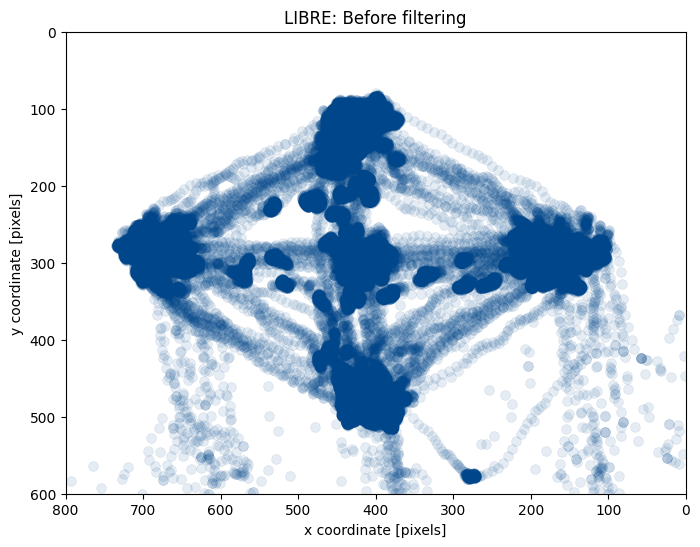

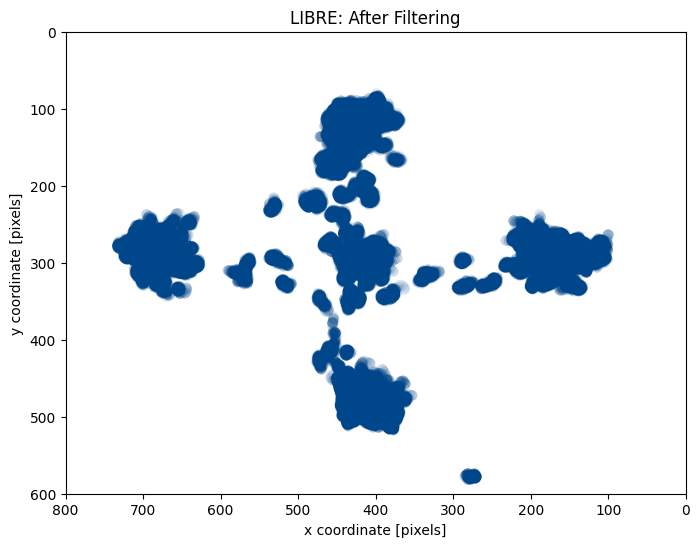

In [21]:
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE_raw['x_coordinate']
Y_coord = coor_data_LIBRE_raw['y_coordinate']
fig, ax= plt.subplots(figsize=(8, 6))
# Plot the data, flipping X coordinates and using dots as markers
plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: Before filtering')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
fig, ax= plt.subplots(figsize=(8, 6))
# Plot the data, flipping X coordinates and using dots as markers
plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: After Filtering')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# ============================================================



By far, we initially cleaned data based on the inherent properties in the metadata from EyeLink. And we plotted the fixation evaluation. 

In [22]:
# see cleaned_cell [2]

### Visualize gaze groups

In [23]:

def within_2d_range(x_vals, y_vals, x_range, y_range):
    return np.sum((x_vals >= x_range[0]) & (x_vals <= x_range[1]) &
                      (y_vals >= y_range[0]) & (y_vals <= y_range[1]))
    


def label_correction(labels, counts, intervals):

    interval_len = len(labels)
    if intervals == 5000:
        intervals = [intervals]*interval_len
        print(intervals)
    print(f'len of intervals {interval_len} in label_correction')
    corrected_labels = []
    for i, label in enumerate(labels):
        if (label=='center') & (i>5) & (i<interval_len-1-5):
            label='invalid'
            print(f'index-{i}: label corrected, at this time there is no center stimulus ')
        if counts[i]<intervals[i]/2:
            label='invalid'
            print(f'index-{i}: label corrected, count of valid points is less than half of interval')
        corrected_labels.append(label)

    return corrected_labels
            
    

In [24]:
# see cleaned_cell [3]

Subjects saccaded from one position to another need a short delay, so the actual gaze points are not necessarily aligned with the stimuli occurring. We need to adjust a bit or tolerate such delay.

# More detailed classification

In [34]:
# More detailed classification
# play with the timestamp and the first fixation point -> finer subject delay.
metadata['LoggedMessages']

dot_message_1 = "ET: Start routine 'centered_dot'"
dot_message_2 = "ET: Start routine 'dots'"
dot_message_3 = 'ET: dot moved!'


dot_message = []
for index, element in enumerate(metadata['LoggedMessages']):
    if (element[1] == dot_message_1) or (element[1] == dot_message_2) or (element[1] == dot_message_3):
        dot_message.append(element)

print(f'total length: {len(dot_message)}')


first_dot_timestamp = dot_message[0][0]
dot_message = [[timestamp - first_dot_timestamp, msg] for timestamp, msg in dot_message]
# dot_message = [[timestamp, msg] for timestamp, msg in dot_message]
print('Shifted')
print(dot_message[-1])

print(dot_message)

total length: 131
Shifted
[651403, "ET: Start routine 'centered_dot'"]
[[0, "ET: Start routine 'centered_dot'"], [4991, "ET: Start routine 'centered_dot'"], [9991, "ET: Start routine 'centered_dot'"], [14992, "ET: Start routine 'centered_dot'"], [20008, "ET: Start routine 'centered_dot'"], [25008, "ET: Start routine 'centered_dot'"], [30008, "ET: Start routine 'dots'"], [35008, 'ET: dot moved!'], [40009, 'ET: dot moved!'], [45026, 'ET: dot moved!'], [50042, "ET: Start routine 'dots'"], [55059, 'ET: dot moved!'], [60075, 'ET: dot moved!'], [65076, 'ET: dot moved!'], [70092, "ET: Start routine 'dots'"], [75108, 'ET: dot moved!'], [80109, 'ET: dot moved!'], [85125, 'ET: dot moved!'], [90126, "ET: Start routine 'dots'"], [95142, 'ET: dot moved!'], [100159, 'ET: dot moved!'], [105160, 'ET: dot moved!'], [110179, "ET: Start routine 'dots'"], [115193, 'ET: dot moved!'], [120209, 'ET: dot moved!'], [125210, 'ET: dot moved!'], [130211, "ET: Start routine 'dots'"], [135227, 'ET: dot moved!'], [1

In [35]:
def classify_gaze_region_v2(X_coord, Y_coord, dot_message, sb_delay=0, display=False):
    from collections import Counter
    
    time_len = len(X_coord)
    print(f'time length: {len(X_coord)}')
    # label the dot position
    x_left_range = [600,800]
    x_right_range = [0, 200]
    x_center_range = [300, 500]
    
    y_up_range = [0, 200]
    y_down_range = [400, 600]
    y_center_range = [200, 400]
    labels = []
    counts = []

     
    if dot_message == []:
        interval = 5000
        default_range = range(sb_delay, int(time_len), interval)
        time_range = default_range
        print('default time range')
        intervals = [interval] * len(default_range)
        
    else:
        print(f'len of dot messages {len(dot_message)}')
        dot_time_range = [item[0]+sb_delay for item in dot_message]
        time_range = dot_time_range
        time_range.append(dot_time_range[-1])
        print('time range with ET message')

        # Extract the time values (first elements of each pair)
        time_values = [item[0] for item in dot_message]
        
        # Compute the time intervals
        intervals = [time_values[i] - time_values[i - 1] for i in range(1, len(time_values))]
        intervals.append(5000)
        print(f'Before appending: time duration of intervals: {sum(intervals)}')
        for i in range(10):
            if len(intervals) != len(time_range):
                intervals.append(5000)
                print('append +1 interval')
            else:
                break
        print("Time Intervals:", intervals)
        print(f'len of intervals: {len(intervals)}')

    print(f'length of time_range {len(time_range)}')
    
    for start_time, interval in zip(time_range, intervals):
        end_time = start_time + interval
        x_interval = X_coord[start_time:end_time]
        y_interval = Y_coord[start_time:end_time]
        
        # Calculate counts for each region
        left_count = within_2d_range(x_interval, y_interval, x_left_range, y_center_range)
        right_count = within_2d_range(x_interval, y_interval, x_right_range, y_center_range)
        center_count = within_2d_range(x_interval, y_interval, x_center_range, y_center_range)
        up_count = within_2d_range(x_interval, y_interval, x_center_range, y_up_range)
        down_count = within_2d_range(x_interval, y_interval, x_center_range, y_down_range)
    
        region_counts = {
            'left': left_count,
            'right': right_count,
            'center': center_count,
            'up': up_count,
            'down': down_count,
        }
        
        max_label, max_count = max(region_counts.items(), key=lambda item: item[1])
        # Append the result
        if max_count > 0:
            labels.append(max_label)
            counts.append(max_count)
        else:
            labels.append('unknown')
            counts.append(0)
        
    if display:
        for i, label in enumerate(labels):
            print(f'Interval {i}-{(i+1)}: {label} -> {counts[i]}')

    return labels, counts, intervals



time length: 657402
len of dot messages 131
time range with ET message
Before appending: time duration of intervals: 656403
append +1 interval
Time Intervals: [4991, 5000, 5001, 5016, 5000, 5000, 5000, 5001, 5017, 5016, 5017, 5016, 5001, 5016, 5016, 5001, 5016, 5001, 5016, 5017, 5001, 5019, 5014, 5016, 5001, 5001, 5016, 5018, 5015, 5018, 5015, 5017, 5001, 5016, 5016, 5001, 5017, 5017, 5017, 5015, 5001, 5017, 5001, 5015, 5002, 5016, 5016, 5001, 5015, 5002, 5016, 5018, 5015, 5018, 5016, 5000, 5017, 5017, 5016, 5000, 5017, 5001, 5016, 5000, 5017, 5001, 5016, 5016, 5017, 5001, 5016, 5000, 5000, 5019, 5014, 5017, 5001, 5017, 5017, 5016, 5017, 5017, 5016, 5017, 5002, 5016, 5015, 5001, 5000, 5017, 5016, 5017, 5017, 5017, 5016, 5017, 5000, 5017, 5016, 5001, 5016, 5018, 5015, 5001, 5017, 5016, 5017, 5017, 5000, 5001, 5016, 5017, 5016, 5001, 5016, 5000, 5016, 5002, 5016, 5016, 5002, 5003, 5013, 5016, 5017, 5019, 4999, 5001, 4999, 5000, 5000, 5000]
len of intervals: 132
length of time_range 132
l

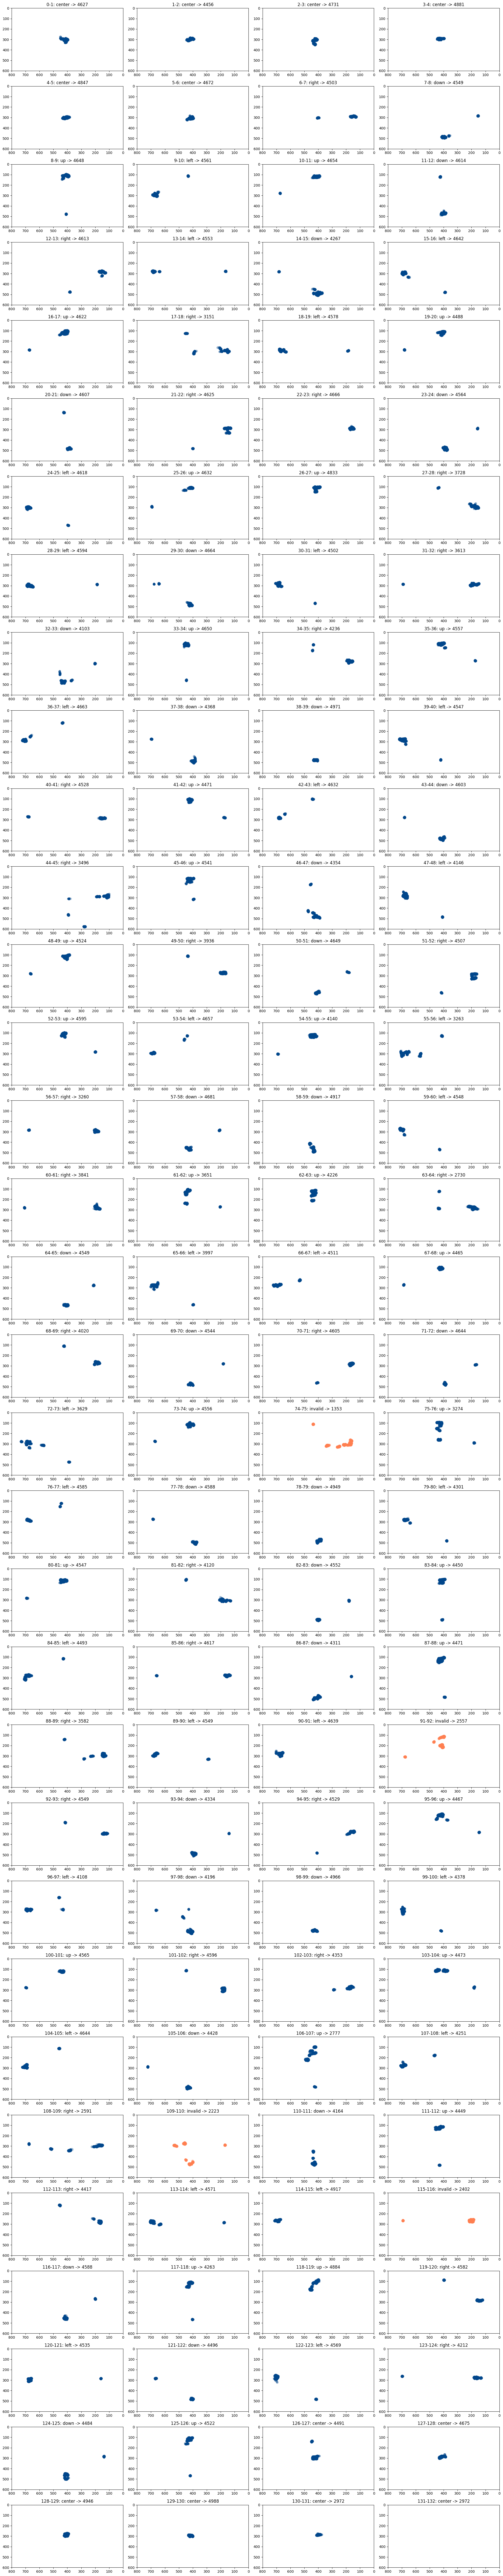

In [36]:
import json
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
labels,counts, intervals = classify_gaze_region_v2(X_coord, Y_coord, dot_message, sb_delay=0, display=False)

with open(f'./labels/labels_subj_00{subject_idx}.json', 'w') as file:
    json.dump(labels, file)
    
corr_labels = label_correction(labels, counts, intervals)
with open(f'./labels/corrected_labels_subj_00{subject_idx}.json', 'w') as file:
    json.dump(corr_labels, file)

sb_delay = 10
num_rows=33
num_cols=4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*(num_cols+1), 3*(num_rows+1)))
axes = axes.flatten()
invalid_indices = [i for i, element in enumerate(corr_labels) if element == "invalid"]
print(invalid_indices)
  
for i, ax in enumerate(axes):
    if i<len(dot_message):
        x = X_coord[dot_message[i][0]+sb_delay:dot_message[i][0]+sb_delay+intervals[i]]
        y = Y_coord[dot_message[i][0]+sb_delay:dot_message[i][0]+sb_delay+intervals[i]]
    else:
        x = X_coord[dot_message[-1][0]+sb_delay+intervals[-1]:]
        y = Y_coord[dot_message[-1][0]+sb_delay+intervals[-1]:]
        
    if i in invalid_indices:
        ax.scatter(x, y, c='coral', alpha=0.1, edgecolors='coral')
    else:
        ax.scatter(x, y, c='#00468b', alpha=0.1, edgecolors='#00468b')
    ax.set_title(f'{i}-{i+1}: {corr_labels[i]} -> {counts[i]}')
    ax.set_xlim([0, 800])
    ax.set_ylim([0, 600])
    ax.invert_xaxis()
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [40]:
print(len(dot_message))
print(len(intervals))

print(len(labels))
print(len(corr_labels))

131
132
132
132


## Generate the raw masks: 5 masks
According to the stimuli intervals

In [154]:
coor_data_dot_raw = copy.deepcopy(coor_data_LIBRE_raw)

print(len(coor_data_dot_raw))

coor_data_dot_raw = coor_data_dot_raw.reset_index(drop=True)


if subject_idx == 1:
    offset_first_dot_mriStart = 1244 #1243.9 -> 1244
elif subject_idx == 2:
    offset_first_dot_mriStart = -475
else:
    offset_first_dot_mriStart= 1451 #1450.5 -> 1451

# I want to generate a table, concatenate the labels along with the recordings.
# for example, I have 657402 coordinates pandas dataframe, and I have subsequent 131 intervals and 131 labels,
# I want to add the labels to the dataframe as a new column according to the intervals.



# Initialize a new column for labels
coor_data_dot_raw['label'] = None

# Assign labels based on intervals
for i, dot_m in enumerate(dot_message):
    start = dot_m[0]
    end = start+intervals[i]
    coor_data_dot_raw.loc[start:end, 'label'] = labels[i]

# Check result
# print(coor_data_dot_raw[dot_message[19][0]:dot_message[19][0]+intervals[19]])



657402


In [155]:
coor_data_dot_offset = coor_data_dot_raw[offset_first_dot_mriStart:].reset_index(drop=True)
mri_duration = 655240
coor_data_dot_offset = coor_data_dot_offset[:mri_duration]
print(len(coor_data_dot_offset))
print(coor_data_dot_offset)
unique_labels = coor_data_dot_offset["label"].unique()
print("Unique labels:", unique_labels)
coor_data_dot_offset[coor_data_dot_offset["label"] == 'center'][-2000:-1990]

655240
        x_coordinate  y_coordinate   label
0         402.500000    300.700012  center
1         402.899994    299.799988  center
2         403.000000    300.000000  center
3         402.399994    302.200012  center
4         401.700012    304.299988  center
...              ...           ...     ...
655235           NaN           NaN    None
655236           NaN           NaN    None
655237           NaN           NaN    None
655238           NaN           NaN    None
655239           NaN           NaN    None

[655240 rows x 3 columns]
Unique labels: ['center' 'right' 'down' 'up' 'left' None]


,x_coordinate,y_coordinate,label
653160,395.500000,283.700012,center
653161,396.299988,283.200012,center
653162,396.799988,282.600006,center
653163,397.299988,282.399994,center
653164,397.299988,282.299988,center
653165,396.399994,282.600006,center
653166,395.399994,284.600006,center
653167,394.799988,286.600006,center
653168,394.299988,286.600006,center
653169,394.000000,284.799988,center


In [156]:
# Generate 5 raw mask
import os
import scipy.io as sio

def generate_mask(coor_data, label_type='label', label='up'):

    # Generate the mask
    raw_mask = np.where(coor_data[label_type] == label, 1, 0)
    
    # Check the result
    print("Mask:", raw_mask)
    print("Mask shape:", raw_mask.shape)

    

    return raw_mask

label_list = ['up', 'down', 'left', 'right', 'center', 'invalid']
raw_mask_5p = []
raw_mask_up = generate_mask(coor_data_dot_offset, label_type='label', label=label_list[0])
raw_mask_5p.append(raw_mask_up)

raw_mask_down = generate_mask(coor_data_dot_offset, label_type='label', label=label_list[1])
raw_mask_5p.append(raw_mask_down)

raw_mask_left = generate_mask(coor_data_dot_offset, label_type='label', label=label_list[2])
raw_mask_5p.append(raw_mask_left)

raw_mask_right = generate_mask(coor_data_dot_offset,label_type='label', label=label_list[3])
raw_mask_5p.append(raw_mask_right)

raw_mask_center = generate_mask(coor_data_dot_offset,label_type='label', label=label_list[4])
raw_mask_5p.append(raw_mask_center)

coor_data_dot_offset[raw_mask_center.astype(bool)]

save_mask = True
if save_mask:
    for m_idx in range(5):
        save_mask_path = f'./masks/subject_{subject_idx}_raw_mask_{label_list[m_idx]}.mat'
        sio.savemat(save_mask_path, {'array': raw_mask_5p[m_idx]})
        print(f'The mask file has been saved here: {save_mask_path}')
        
  



Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
Mask: [1 1 1 ... 0 0 0]
Mask shape: (655240,)
The mask file has been saved here: ./masks/subject_1_raw_mask_up.mat
The mask file has been saved here: ./masks/subject_1_raw_mask_down.mat
The mask file has been saved here: ./masks/subject_1_raw_mask_left.mat
The mask file has been saved here: ./masks/subject_1_raw_mask_right.mat
The mask file has been saved here: ./masks/subject_1_raw_mask_center.mat


## Generate the location masks: 5 masks
According to the absolute locations

In [157]:
coor_data_dot_raw = copy.deepcopy(coor_data_LIBRE_raw)
print(len(coor_data_dot_raw))
coor_data_dot_raw = coor_data_dot_raw.reset_index(drop=True)


if subject_idx == 1:
    offset_first_dot_mriStart = 1244 #1243.9 -> 1244
elif subject_idx == 2:
    offset_first_dot_mriStart = -475
else:
    offset_first_dot_mriStart= 1451 #1450.5 -> 1451

# Initialize a new column for labels
coor_data_dot_raw['lc_label'] = None


coor_data_dot_offset = coor_data_dot_raw[offset_first_dot_mriStart:].reset_index(drop=True)
mri_duration = 655240
coor_data_dot_offset = coor_data_dot_offset[:mri_duration]
print(len(coor_data_dot_offset))
print(coor_data_dot_offset)




657402
655240
        x_coordinate  y_coordinate lc_label
0         402.500000    300.700012     None
1         402.899994    299.799988     None
2         403.000000    300.000000     None
3         402.399994    302.200012     None
4         401.700012    304.299988     None
...              ...           ...      ...
655235           NaN           NaN     None
655236           NaN           NaN     None
655237           NaN           NaN     None
655238           NaN           NaN     None
655239           NaN           NaN     None

[655240 rows x 3 columns]


In [158]:
# Define the ranges
x_left_range = [600, 800]
x_right_range = [0, 200]
x_center_range = [300, 500]

y_up_range = [0, 200]
y_down_range = [400, 600]
y_center_range = [200, 400]

# Function to classify coordinates
def classify_region(x, y):
    if x_center_range[0] <= x <= x_center_range[1]:
        if y_up_range[0] <= y <= y_up_range[1]:
            return "up"
        elif y_down_range[0] <= y <= y_down_range[1]:
            return "down"
        elif y_center_range[0] <= y <= y_center_range[1]:
            return "center"
    elif x_left_range[0] <= x <= x_left_range[1]:
        if y_center_range[0] <= y <= y_center_range[1]:
            return "left"
    elif x_right_range[0] <= x <= x_right_range[1]:
        if y_center_range[0] <= y <= y_center_range[1]:
            return "right"
    return "invalid"

# Apply the function to the DataFrame
coor_data_dot_offset['lc_label'] = coor_data_dot_offset.apply(lambda row: classify_region(row['x_coordinate'], row['y_coordinate']), axis=1)

# Display the resulting DataFrame
print(coor_data_dot_offset)
nan_counts_per_column = coor_data_dot_offset.isna().sum()
print(nan_counts_per_column)

        x_coordinate  y_coordinate lc_label
0         402.500000    300.700012   center
1         402.899994    299.799988   center
2         403.000000    300.000000   center
3         402.399994    302.200012   center
4         401.700012    304.299988   center
...              ...           ...      ...
655235           NaN           NaN  invalid
655236           NaN           NaN  invalid
655237           NaN           NaN  invalid
655238           NaN           NaN  invalid
655239           NaN           NaN  invalid

[655240 rows x 3 columns]
x_coordinate    7531
y_coordinate    7884
lc_label           0
dtype: int64


In [159]:
# Generate 5 raw mask
import os
import scipy.io as sio


label_list = ['up', 'down', 'left', 'right', 'center', 'invalid']
raw_mask_lc = []
raw_mask_up = generate_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[0])
print(np.sum(raw_mask_up))
raw_mask_lc.append(raw_mask_up)

raw_mask_down = generate_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[1])
print(np.sum(raw_mask_down))
raw_mask_lc.append(raw_mask_down)

raw_mask_left = generate_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[2])
print(np.sum(raw_mask_left))
raw_mask_lc.append(raw_mask_left)

raw_mask_right = generate_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[3])
print(np.sum(raw_mask_right))
raw_mask_lc.append(raw_mask_right)

raw_mask_center = generate_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[4])
print(np.sum(raw_mask_center))
raw_mask_lc.append(raw_mask_center)

coor_data_dot_offset[raw_mask_center.astype(bool)]

save_mask = True
if save_mask:
    for m_idx in range(5):
        save_mask_path = f'./masks/subject_{subject_idx}_lc_mask_{label_list[m_idx]}.mat'
        sio.savemat(save_mask_path, {'array': raw_mask_lc[m_idx]})
        print(f'The mask file has been saved here: {save_mask_path}')
        
  



Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
142039
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
145272
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
145780
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
127916
Mask: [1 1 1 ... 0 0 0]
Mask shape: (655240,)
66463
The mask file has been saved here: ./masks/subject_1_lc_mask_up.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_down.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_left.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_right.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_center.mat


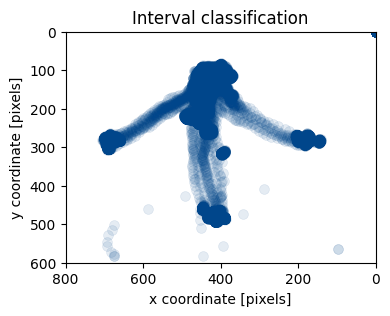

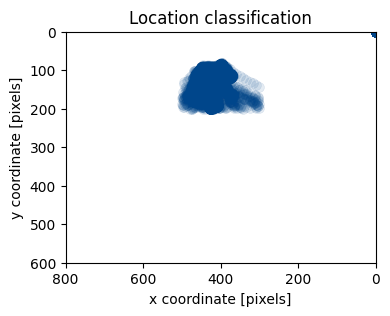

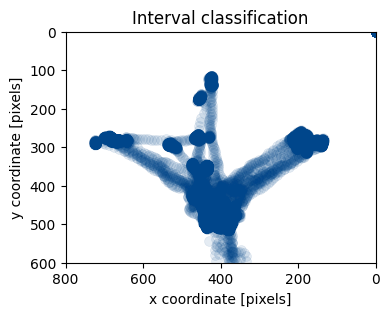

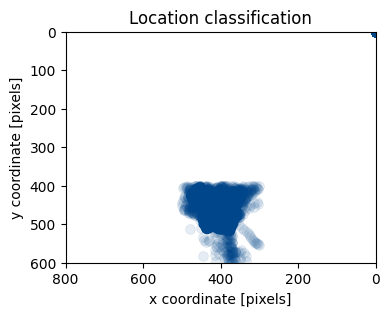

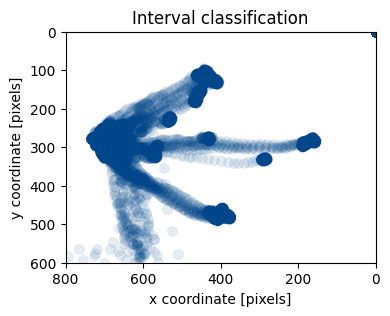

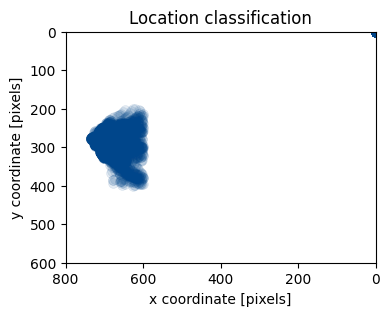

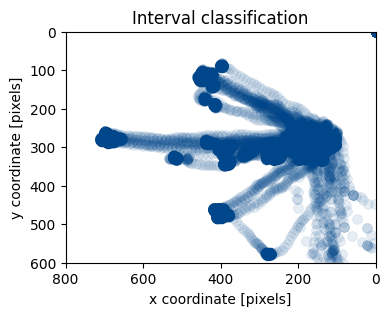

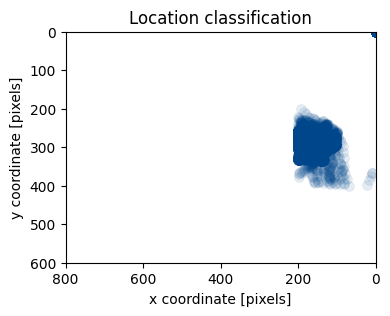

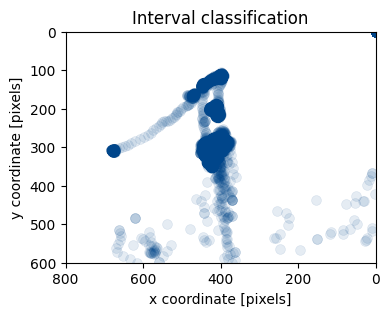

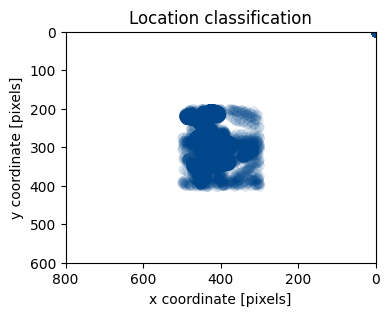

In [160]:
for idx in range(5):
    # Example data (replace with your actual data)
    
    X_coord = coor_data_dot_offset['x_coordinate']*raw_mask_5p[idx]
    Y_coord = coor_data_dot_offset['y_coordinate']*raw_mask_5p[idx]
    fig, ax= plt.subplots(figsize=(4, 3))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title('Interval classification')
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    # ============================================================
    # Example data (replace with your actual data)
    X_coord = coor_data_dot_offset['x_coordinate']*raw_mask_lc[idx]
    Y_coord = coor_data_dot_offset['y_coordinate']*raw_mask_lc[idx]
    
    fig, ax= plt.subplots(figsize=(4, 3))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title('Location classification')
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    # ============================================================
    np.sum(raw_mask_5p[0] != raw_mask_lc[0] )

## Generate the filtered 5 mask
based on the filtered coordinate



In [161]:
# def find_mean(x)

coor_data_dot_filtered = copy.deepcopy(coor_data_LIBRE)
print(len(coor_data_dot_raw))
coor_data_dot_filtered = coor_data_dot_filtered.reset_index(drop=True)

if subject_idx == 1:
    offset_first_dot_mriStart = 1244 #1243.9 -> 1244
elif subject_idx == 2:
    offset_first_dot_mriStart = -475
else:
    offset_first_dot_mriStart= 1451 #1450.5 -> 1451

coor_data_dot_filtered_offset = coor_data_dot_filtered[offset_first_dot_mriStart:].reset_index(drop=True)
mri_duration = 655240
coor_data_dot_filtered_offset = coor_data_dot_filtered_offset[:mri_duration]
print(len(coor_data_dot_filtered_offset))


nan_counts_per_column = coor_data_dot_filtered_offset.isna().sum()
print(f"\nnum of nan:\n{nan_counts_per_column} \n")
coor_data_dot_filtered_offset['lc_label'] = coor_data_dot_offset['lc_label']
# print(coor_data_dot_filtered_offset)

# Here I want to clean all the NaN elements with label "invalid"
print(f"before processing: {len(coor_data_dot_filtered_offset[coor_data_dot_filtered_offset['lc_label'] == 'invalid'])}")
coor_data_dot_filtered_offset.loc[coor_data_dot_filtered_offset.isna().any(axis=1), 'lc_label'] = "invalid"
print(f"after processing: {len(coor_data_dot_filtered_offset[coor_data_dot_filtered_offset['lc_label'] == 'invalid'])}")

657402
655240

num of nan:
x_coordinate    29426
y_coordinate    29426
dtype: int64 

before processing: 27770
after processing: 46329


In [162]:
label_list = ['up', 'down', 'left', 'right', 'center', 'invalid']
ft_mask_list = []
ft_mask_up = generate_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[0])
print(np.sum(ft_mask_up))
ft_mask_list.append(ft_mask_up)

ft_mask_down = generate_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[1])
print(np.sum(ft_mask_down))
ft_mask_list.append(ft_mask_down)

ft_mask_left = generate_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[2])
print(np.sum(ft_mask_left))
ft_mask_list.append(ft_mask_left)

ft_mask_right = generate_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[3])
print(np.sum(ft_mask_right))
ft_mask_list.append(ft_mask_right)

ft_mask_center = generate_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[4])
print(np.sum(ft_mask_center))
ft_mask_list.append(ft_mask_center)

coor_data_dot_filtered_offset[ft_mask_center.astype(bool)]

save_mask = True
if save_mask:
    for m_idx in range(5):
        save_mask_path = f'./masks/subject_{subject_idx}_ft_mask_{label_list[m_idx]}.mat'
        sio.savemat(save_mask_path, {'array': ft_mask_list[m_idx]})
        print(f'The mask file has been saved here: {save_mask_path}')
        
  


Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
137562
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
141780
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
141456
Mask: [0 0 0 ... 0 0 0]
Mask shape: (655240,)
124665
Mask: [1 1 1 ... 0 0 0]
Mask shape: (655240,)
63448
The mask file has been saved here: ./masks/subject_1_ft_mask_up.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_down.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_left.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_right.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_center.mat


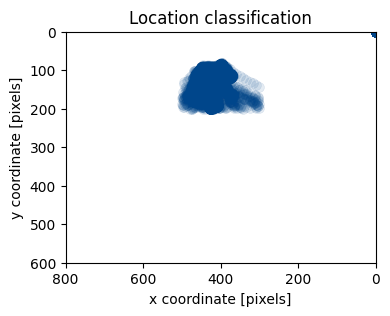

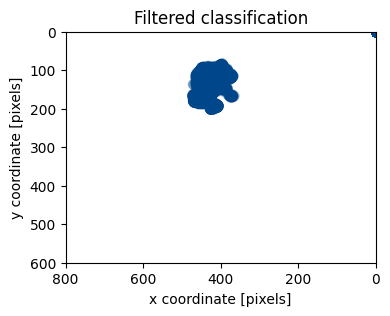

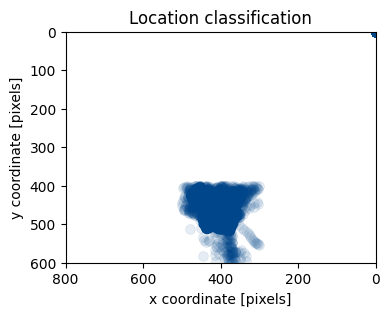

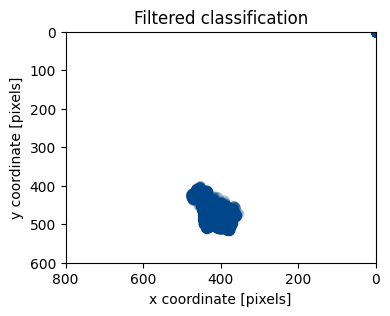

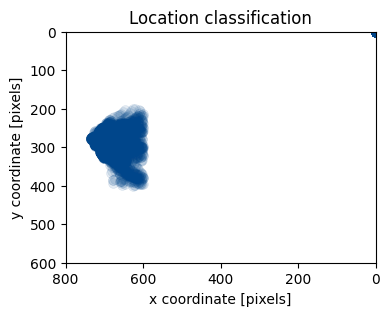

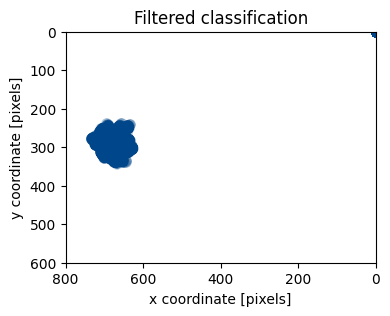

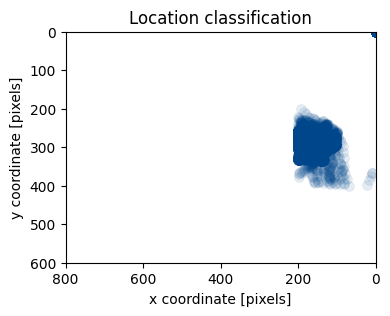

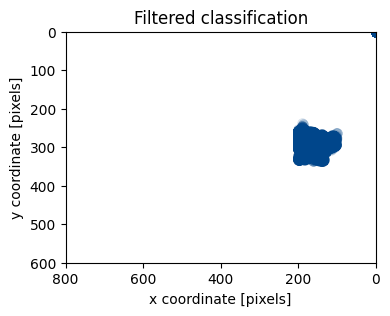

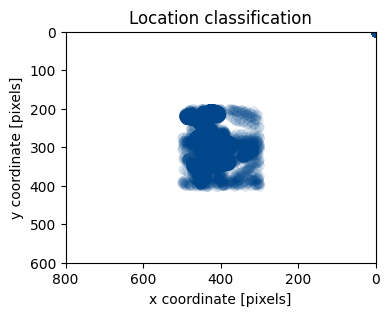

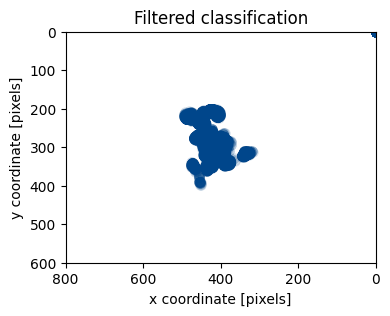

In [163]:
for idx in range(5):
    # ============================================================
    # Example data (replace with your actual data)
    X_coord = coor_data_dot_offset['x_coordinate']*raw_mask_lc[idx]
    Y_coord = coor_data_dot_offset['y_coordinate']*raw_mask_lc[idx]
    
    fig, ax= plt.subplots(figsize=(4, 3))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title('Location classification')
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    # ============================================================
    # Example data (replace with your actual data)
    X_coord = coor_data_dot_filtered_offset['x_coordinate']*ft_mask_list[idx]
    Y_coord = coor_data_dot_filtered_offset['y_coordinate']*ft_mask_list[idx]
    fig, ax= plt.subplots(figsize=(4, 3))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title('Filtered classification')
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    np.sum(raw_mask_lc[0] != ft_mask_list[0] )

### Filtered the coor_data_dot_filtered_offset

Region by the gaze points


To find the median coor of the point clouds
The mean position of the gaze region: [683.5, 283.70001220703125] (px)
To calculate visual angles w.r.t. points
655240
To calculate the displacement in both directions (mm)
655240
To generate discard masks for x and y direction...


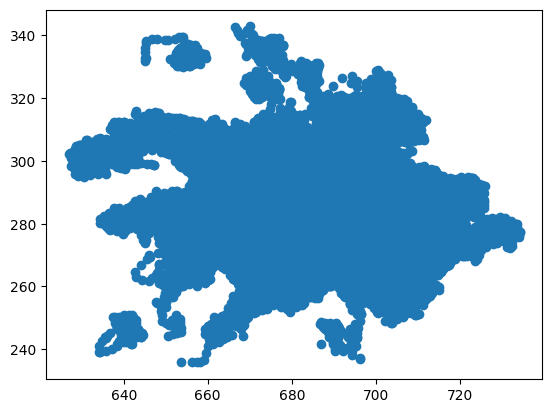

In [254]:
from mask_clean import find_mean_position, cal_angles, cal_disp, filter_criteria, filter_XY_with_mask, visualization_func

# left mask
coor_data_left = copy.deepcopy(coor_data_dot_filtered_offset)

coor_data_left['x_coordinate'] = coor_data_left['x_coordinate']*ft_mask_list[2]
coor_data_left['y_coordinate'] = coor_data_left['y_coordinate']*ft_mask_list[2]
mask_zero = (coor_data_left['x_coordinate'] == 0) & (coor_data_left['y_coordinate'] == 0)
coor_data_left.loc[mask_zero, ['x_coordinate'] ] = np.nan
coor_data_left.loc[mask_zero, ['y_coordinate'] ] = np.nan

X_coord_left = coor_data_left['x_coordinate']
Y_coord_left = coor_data_left['y_coordinate']
# print(X_coord_left)
# print(Y_coord_left)
plt.scatter(X_coord_left, Y_coord_left)

med_coor_left = find_mean_position(X_coord_left, Y_coord_left)
theta_h_, theta_h_m, rho_v_, rho_v_m = cal_angles(X_coord_left, Y_coord_left, med_coor_left)
print(len(theta_h_))
h_dis_left, v_dis_left = cal_disp(theta_h_, theta_h_m, rho_v_, rho_v_m)
print(len(v_dis_left))

# print(v_dis_left)
criteria_ratio=0.3
discarded_x_mask, discarded_y_mask = filter_criteria(h_dis_left, v_dis_left, criteria_ratio=criteria_ratio)
# preserve_mask = ~(discarded_x_mask | discarded_y_mask)



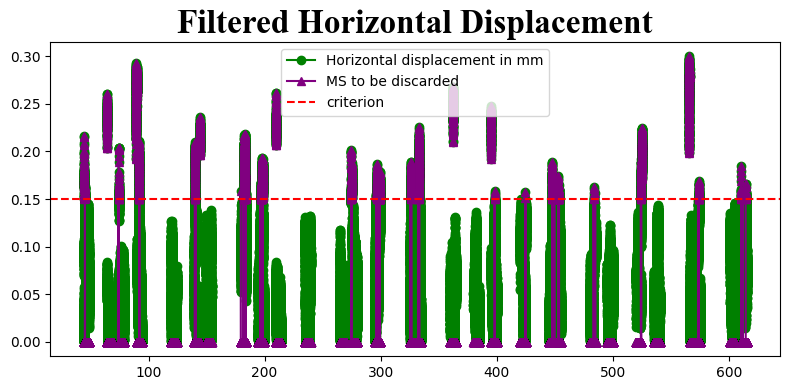

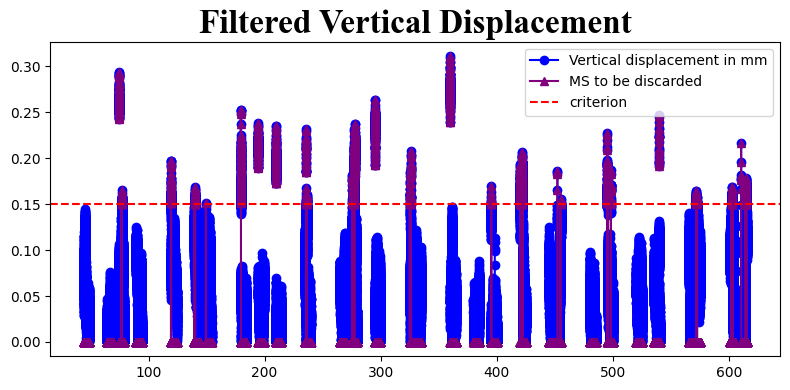

In [257]:
plot_h_v_disp(h_dis_left, v_dis_left, discarded_x_mask, discarded_y_mask, criteria_ratio=criteria_ratio)



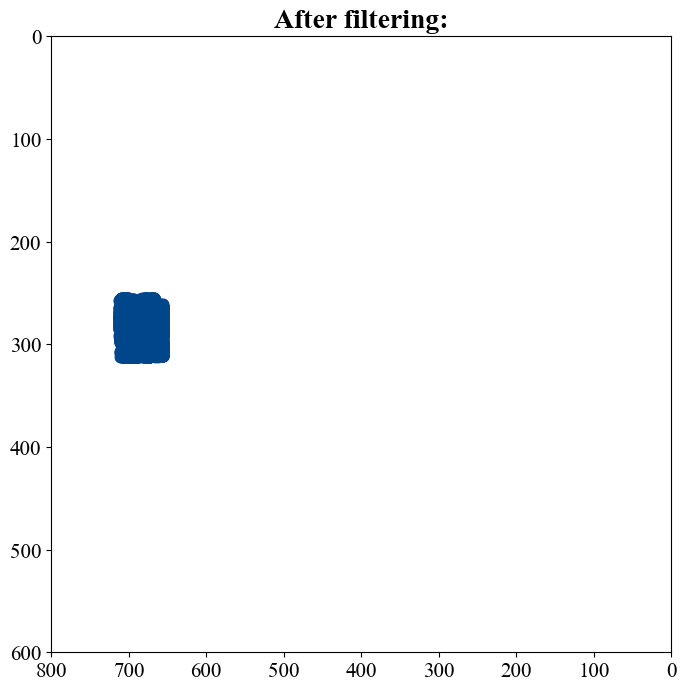

In [258]:
coor_data_left_clean, Preserve_mask, Discard_mask = filter_XY_with_mask(coor_data_left, discarded_x_mask, 
                                                                        discarded_y_mask, seq_name=None)

sum of raw mask: 145780
sum of filtered mask: 141456
sum of mask clean: 128890
if same 0         False
1         False
2         False
3         False
4         False
          ...  
655235    False
655236    False
655237    False
655238    False
655239    False
Name: x_coordinate, Length: 655240, dtype: bool


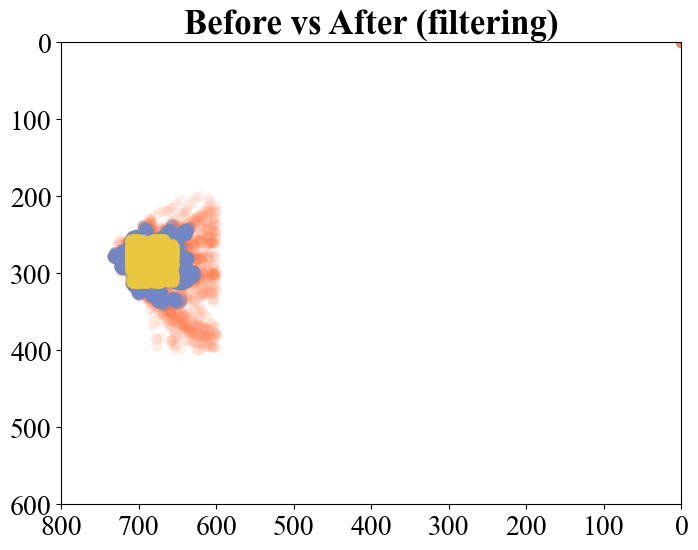

In [260]:

# Visualization of filtered coor data LIBRE
coor_data_raw_left = copy.deepcopy(coor_data_dot_offset)

coor_data_raw_left['x_coordinate'] = coor_data_raw_left['x_coordinate']*raw_mask_lc[2]
coor_data_raw_left['y_coordinate'] = coor_data_raw_left['y_coordinate']*raw_mask_lc[2]
print(f'sum of raw mask: {sum(raw_mask_lc[2])}')
print(f'sum of filtered mask: {sum(ft_mask_list[2])}')
print(f'sum of mask clean: {sum(Preserve_mask)}')
visualization_func(fig_title='Before vs After (filtering)', 
                   coor_data_raw = coor_data_raw_left, coor_data=coor_data_left, coor_data_clean=coor_data_left_clean)



In [262]:
count_true = np.sum(Preserve_mask)
print(count_true)
# Save the Preserve_mask
import os
import scipy.io as sio
save_mask = True

if save_mask:
    mask_name = f'subject_{subject_idx}_mask_clean_{criteria_ratio}_2.mat'
    if subject_idx == 1:
        SAVE_PATH = './masks/'
    elif subject_idx == 2:
        SAVE_PATH = './masks/'
    elif subject_idx == 3:
        SAVE_PATH = './masks/'
 
    
    # Create the folder if it doesn't exist
    os.makedirs(SAVE_PATH, exist_ok=True)
    mask_file = SAVE_PATH + mask_name

    # Save array to a .mat file
    sio.savemat(mask_file, {'array': Preserve_mask})
    print(f'The mask file has been saved here: {mask_file}')

128890
The mask file has been saved here: ./masks/subject_1_mask_clean_0.3_2.mat


655240


In [ ]:
save_Discard_mask = False
print(len(Preserve_mask))
if save_Discard_mask:
    Discard_mask = ~Preserve_mask
    count_true = np.sum(Discard_mask)
    print(count_true)
    # Save the Preserve_mask
    import os
    import scipy.io as sio

    mask_name = f'{FILE_NAME}_discard_mask_meth2_0_33.mat'
    if subject_idx == 1:
        SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub001/230928_anatomical_MREYE_study/ET_EDF/meth2_0_33/")
    elif subject_idx == 2:
        SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub002/230926_anatomical_MREYE_study/ET_EDF/meth2_0_33/")
    elif subject_idx == 3:
        SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub003/230928_anatomical_MREYE_study/ET_EDF/meth2_0_33/")
    else:
         SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub004/230923_anatomical_MREYE_study/ET_EDF/meth2_0_33/")

    # Create the folder if it doesn't exist
    os.makedirs(SAVE_PATH, exist_ok=True)
    mask_file = SAVE_PATH / mask_name

    # Save array to a .mat file
    sio.savemat(mask_file, {'array': Discard_mask})
    print(f'The mask file has been saved here: {mask_file}')

# Multiple Masks

if num=4, divide the valid range into 4 parts

To find the median coor of the point clouds
The mean position of the gaze region: [423.2000122070313, 115.1999969482422] (px)
To calculate visual angles w.r.t. points
655240
To calculate the displacement in both directions (mm)
655240
To generate discard masks for x and y direction...
sum of raw mask: 142039
sum of filtered mask: 137562
sum of mask clean: 112430
The mask file has been saved here: ./masks/subject_1_mask_clean_0.3_0.mat
To find the median coor of the point clouds
The mean position of the gaze region: [409.0, 479.2999877929688] (px)
To calculate visual angles w.r.t. points
655240
To calculate the displacement in both directions (mm)
655240
To generate discard masks for x and y direction...
sum of raw mask: 145272
sum of filtered mask: 141780
sum of mask clean: 122378
The mask file has been saved here: ./masks/subject_1_mask_clean_0.3_1.mat
To find the median coor of the point clouds
The mean position of the gaze region: [683.5, 283.70001220703125] (px)
To calculate visual

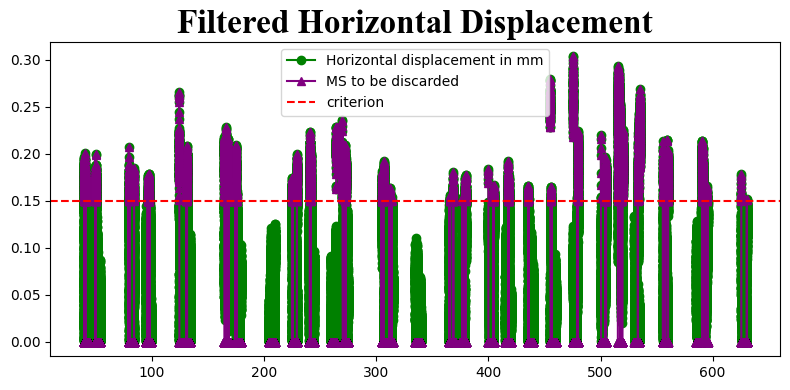

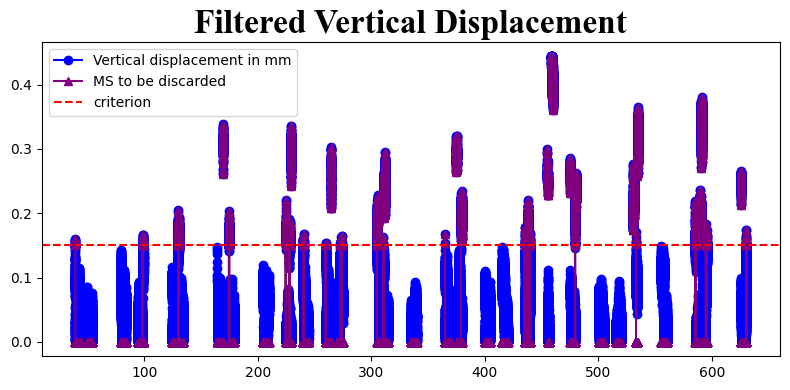

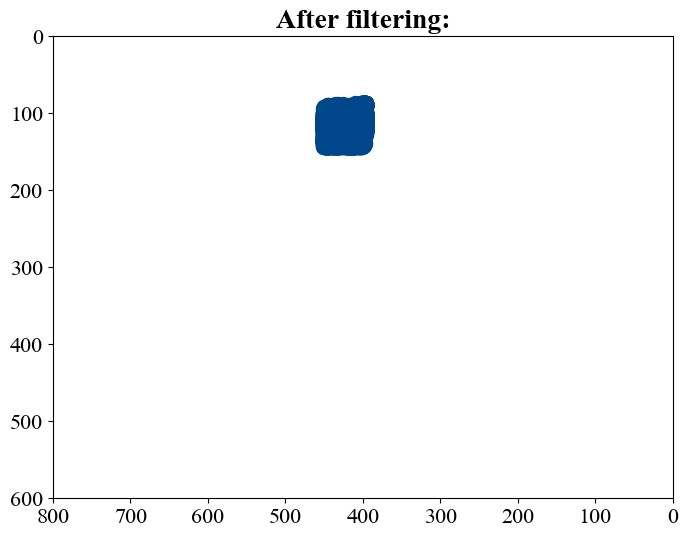

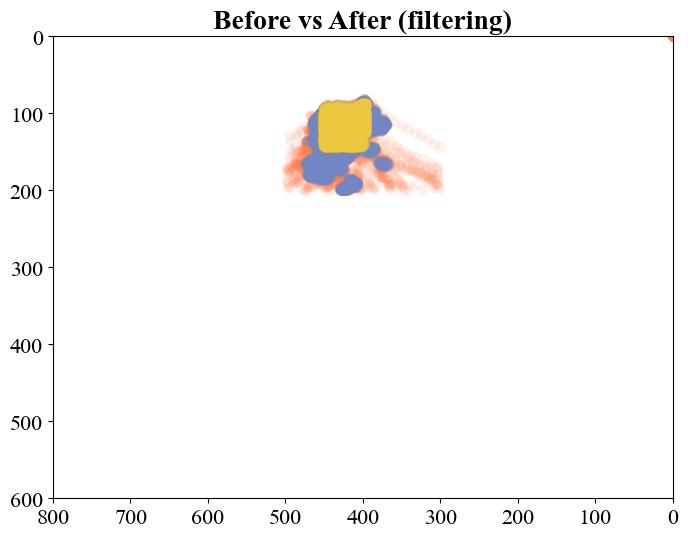

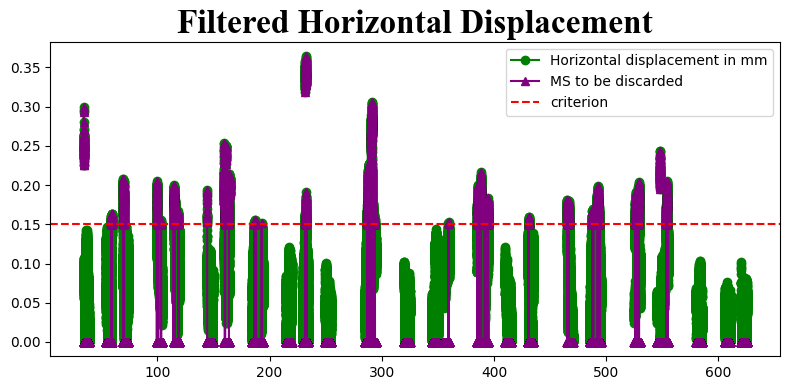

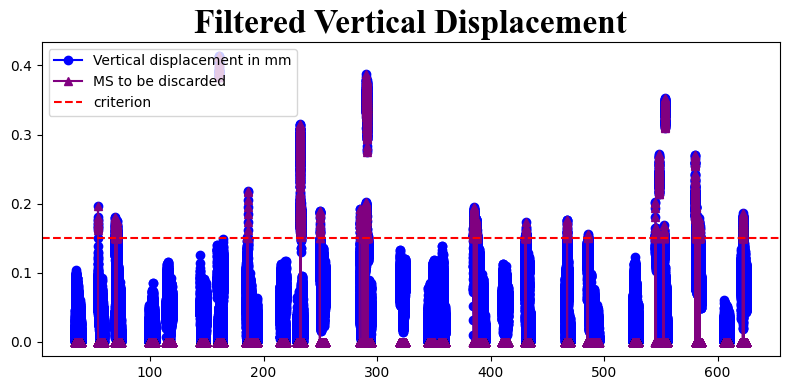

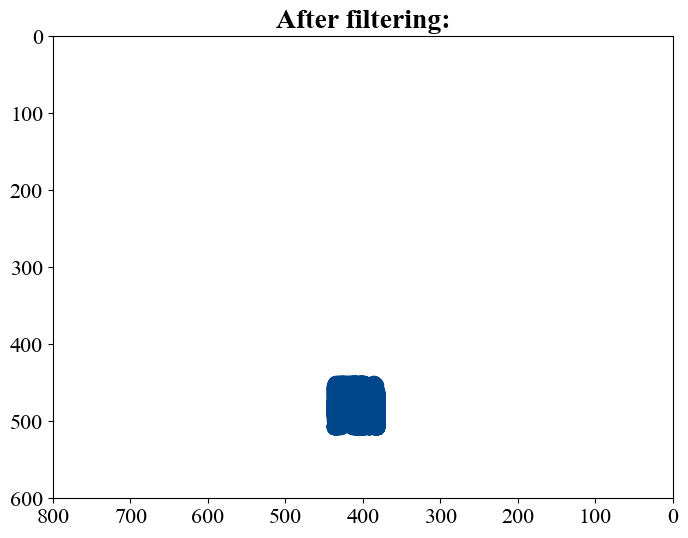

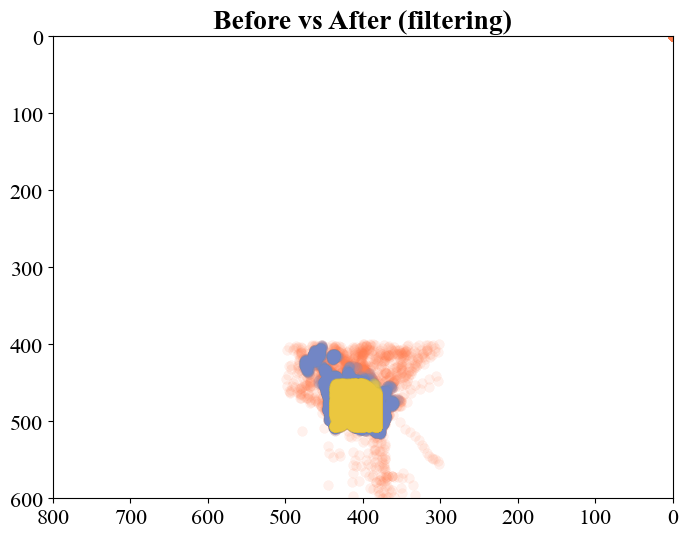

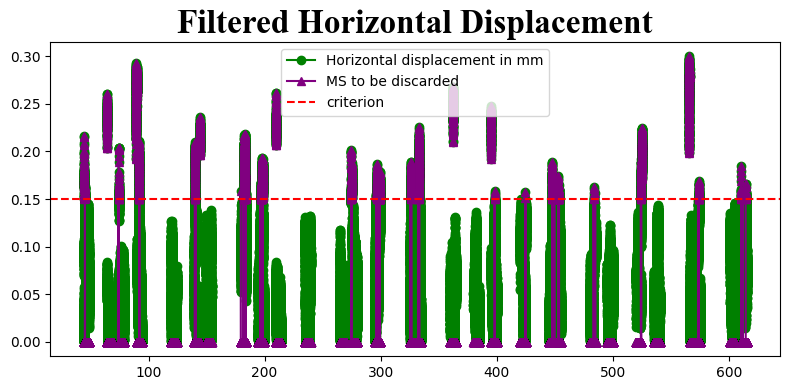

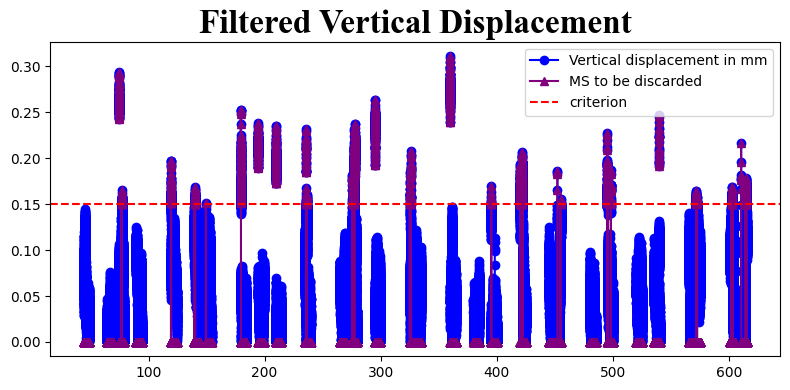

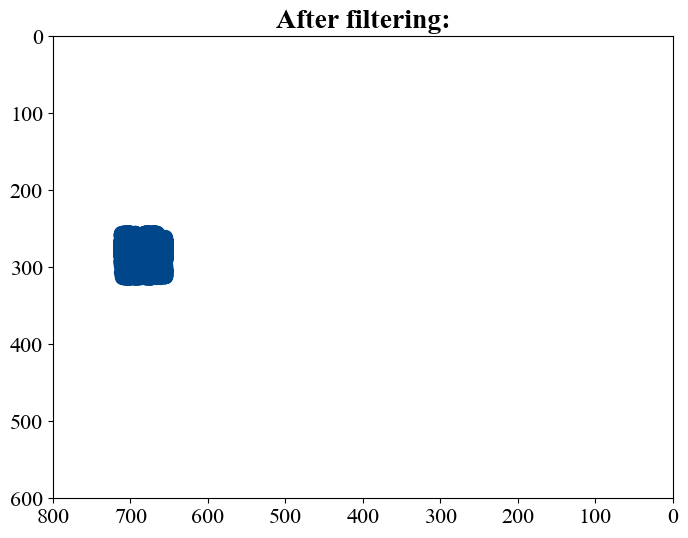

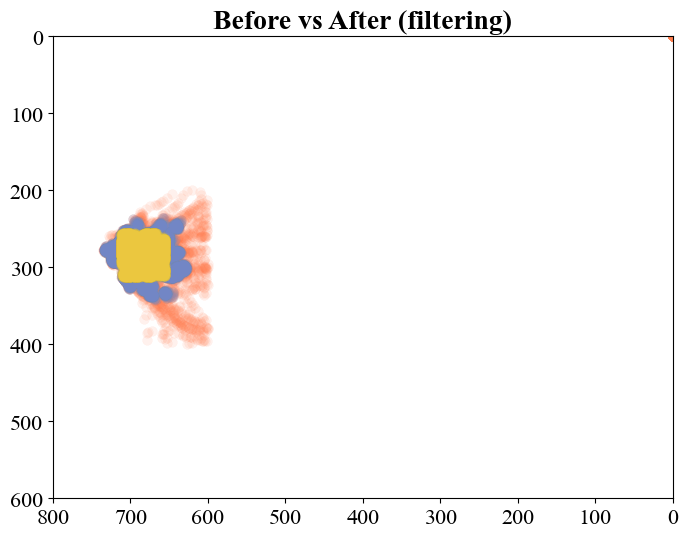

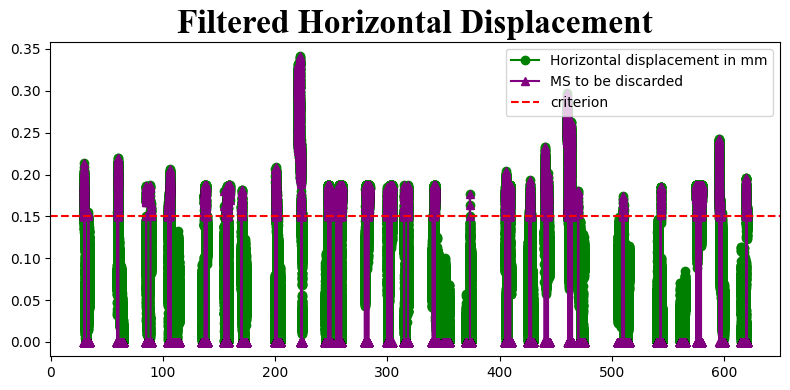

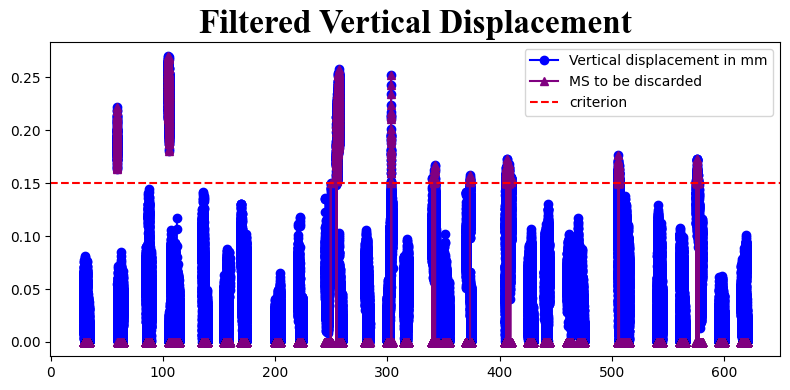

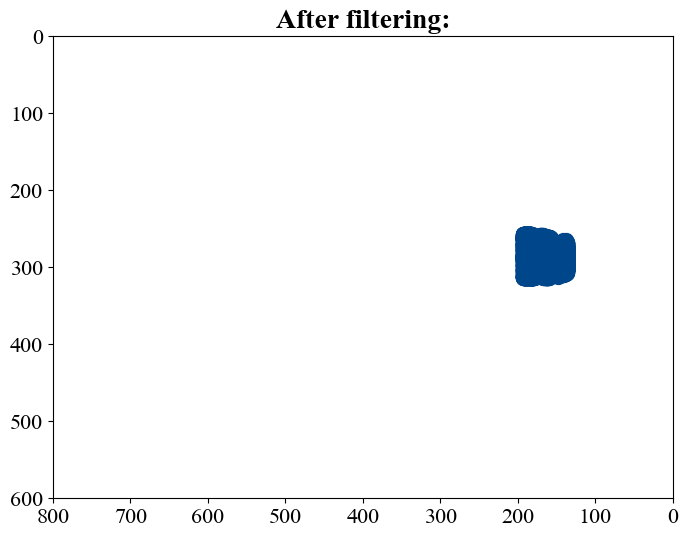

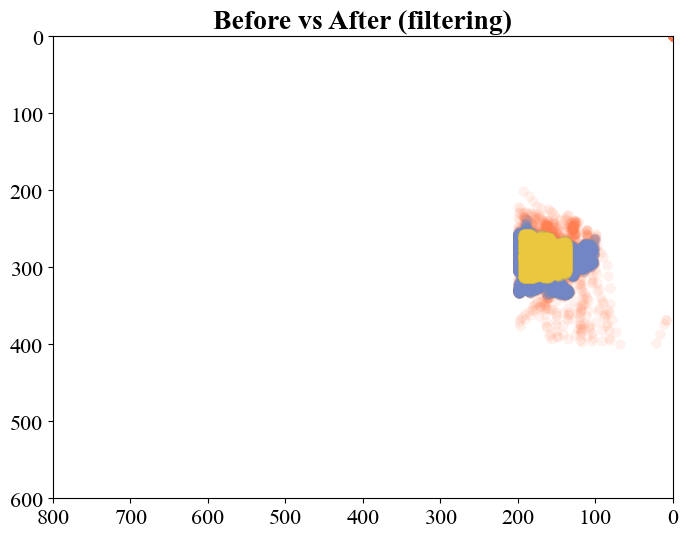

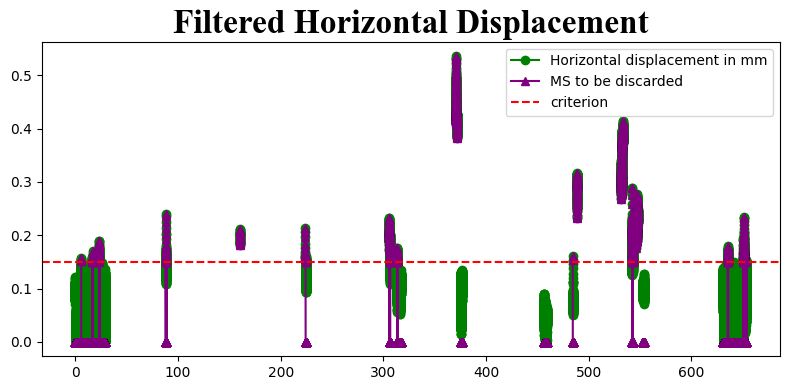

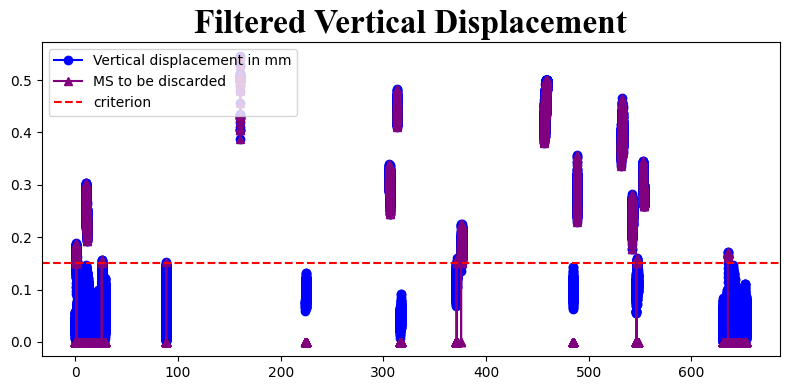

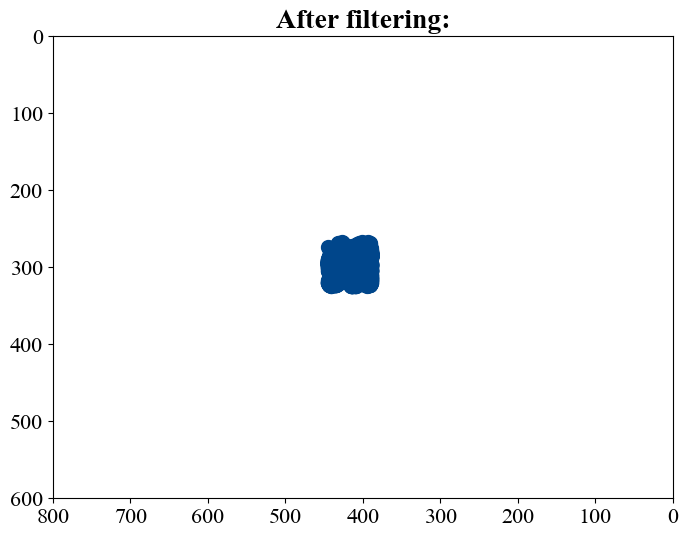

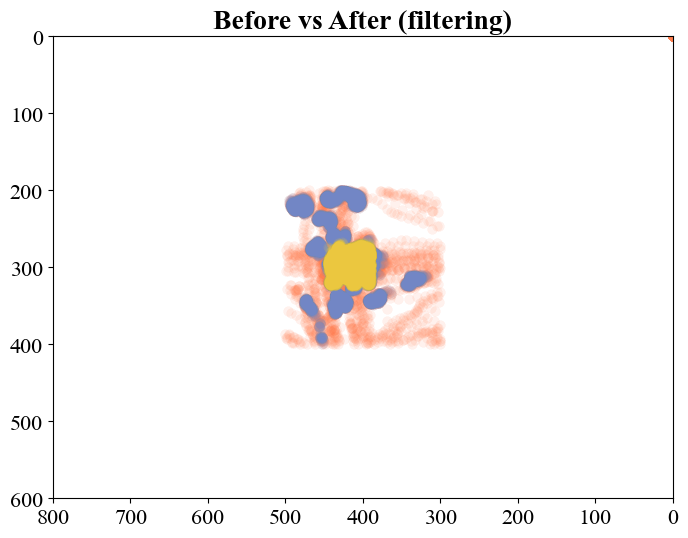

In [268]:
from mask_clean import find_mean_position, cal_angles, cal_disp, filter_criteria, filter_XY_with_mask, visualization_func

for region_idx in range(5):
    # 0:up 1:down 2:left 3:right 4:center mask
    coor_data_region = copy.deepcopy(coor_data_dot_filtered_offset)

    coor_data_region['x_coordinate'] = coor_data_region['x_coordinate']*ft_mask_list[region_idx]
    coor_data_region['y_coordinate'] = coor_data_region['y_coordinate']*ft_mask_list[region_idx]
    mask_zero = (coor_data_region['x_coordinate'] == 0) & (coor_data_region['y_coordinate'] == 0)
    coor_data_region.loc[mask_zero, ['x_coordinate'] ] = np.nan
    coor_data_region.loc[mask_zero, ['y_coordinate'] ] = np.nan
    
    X_coord_region = coor_data_region['x_coordinate']
    Y_coord_region = coor_data_region['y_coordinate']
    # print(X_coord_region)
    # print(Y_coord_region)

    med_coor_region = find_mean_position(X_coord_region, Y_coord_region)
    theta_h_, theta_h_m, rho_v_, rho_v_m = cal_angles(X_coord_region, Y_coord_region, med_coor_region)
    print(len(theta_h_))
    h_dis_region, v_dis_region = cal_disp(theta_h_, theta_h_m, rho_v_, rho_v_m)
    print(len(v_dis_region))

    # print(v_dis_region)
    criteria_ratio=0.3
    discarded_x_mask, discarded_y_mask = filter_criteria(h_dis_region, v_dis_region, criteria_ratio=criteria_ratio)
    # preserve_mask = ~(discarded_x_mask | discarded_y_mask)
    # =================================================================================
    plot_h_v_disp(h_dis_region, v_dis_region, discarded_x_mask, discarded_y_mask, criteria_ratio=criteria_ratio)
    
    coor_data_region_clean, Preserve_mask, Discard_mask = filter_XY_with_mask(coor_data_region, discarded_x_mask, 
                                                                            discarded_y_mask, seq_name=None)
    # ================================================================================= 
    # Visualization of filtered coor data LIBRE
    coor_data_raw_region = copy.deepcopy(coor_data_dot_offset)
    coor_data_raw_region['x_coordinate'] = coor_data_raw_region['x_coordinate']*raw_mask_lc[region_idx]
    coor_data_raw_region['y_coordinate'] = coor_data_raw_region['y_coordinate']*raw_mask_lc[region_idx]
    print(f'sum of raw mask: {sum(raw_mask_lc[region_idx])}')
    print(f'sum of filtered mask: {sum(ft_mask_list[region_idx])}')
    print(f'sum of mask clean: {sum(Preserve_mask)}')
    visualization_func(fig_title='Before vs After (filtering)', 
                       coor_data_raw = coor_data_raw_region, coor_data=coor_data_region, coor_data_clean=coor_data_region_clean)

    # ================================================================================= 
    
    # Save the Preserve_mask
    import os
    import scipy.io as sio
    save_mask = True
    
    if save_mask:
        mask_name = f'subject_{subject_idx}_mask_clean_{criteria_ratio}_{region_idx}.mat'
        SAVE_PATH = './masks/'
            
        # Create the folder if it doesn't exist
        os.makedirs(SAVE_PATH, exist_ok=True)
        mask_file = SAVE_PATH + mask_name
    
        # Save array to a .mat file
        sio.savemat(mask_file, {'array': Preserve_mask})
        print(f'The mask file has been saved here: {mask_file}')
